### Setup

In [1]:
import networkx as nx
import json
import os
import yaml
from textwrap import dedent
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exec(open("/tools/C/nayiri/power/power-analysis/variables.py").read())
exec(open(f"{power_analysis_dir}/util.py").read())

In [3]:
rtl = 'RocketConfig'

### Get power traces

In [4]:
exec(open(f"{power_analysis_dir}/util.py").read())
toggles_riscvdv, jpower_riscvdv, wb_riscvdv = get_workloads_toggles_jpower(riscv_dv)

In [5]:
toggles_torture, jpower_torture, wb_torture = get_workloads_toggles_jpower(riscv_torture)

In [6]:
exec(open(f"{power_analysis_dir}/util.py").read())
toggles_bmark, jpower_bmark, wb_bmark = get_workloads_toggles_jpower(riscv_benchmarks)

towers: Large mismatch btwn data size (354 jpower vs 504 toggles)


### Plot power

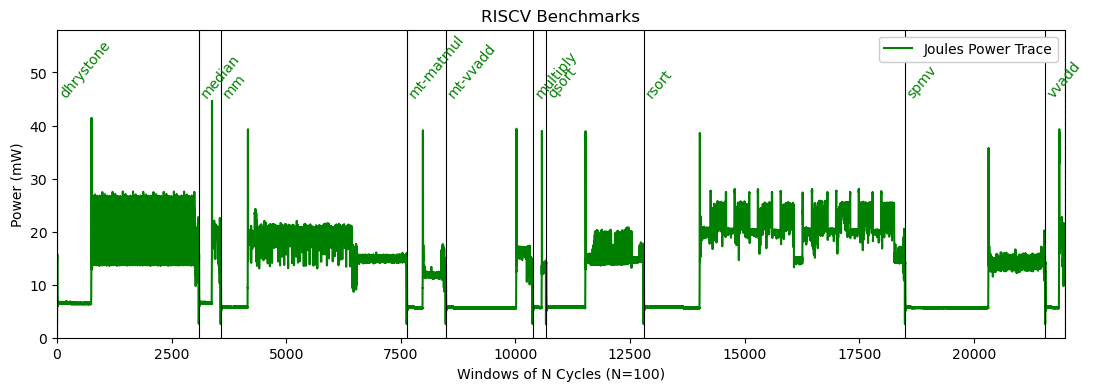

In [21]:
exec(open(f"{power_analysis_dir}/util.py").read())

plot_power(jpower_bmark, workload_borders=wb_bmark, title="RISCV Benchmarks")
plt.ylim(top=max(jpower_bmark)*1.3);

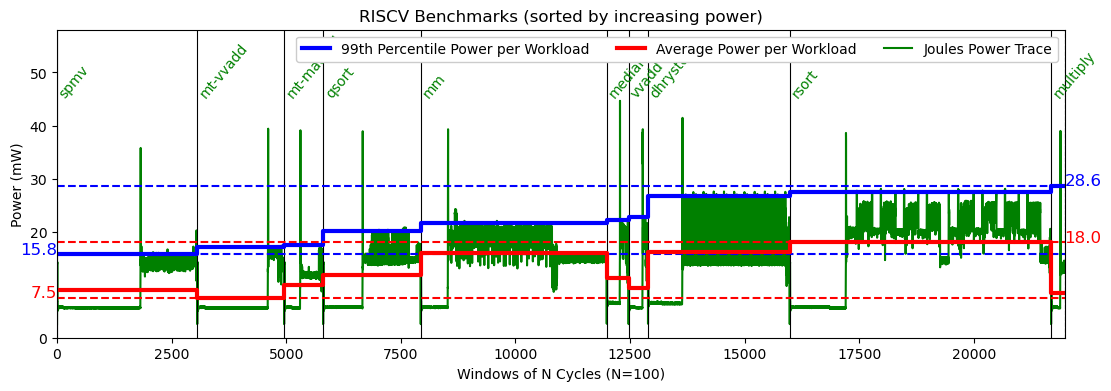

In [23]:
exec(open(f"{power_analysis_dir}/util.py").read())

percentile=99
workload_maxpow_dict = {w:np.percentile(jpower_bmark[b[0]:b[1]], percentile) for w,b in wb_bmark.items()}
workload_avg_dict = {w:np.sum(jpower_bmark[b[0]:b[1]])/(b[1]-b[0]) for w,b in wb_bmark.items()}
jpower_sorted, workload_borders_sorted = reorder_jpower(jpower_bmark, wb_bmark, workload_vals=workload_maxpow_dict)

plot_power(jpower_sorted, workload_borders=workload_borders_sorted)
plot_power_vals(workload_borders_sorted, workload_maxpow_dict, c='b', label=f'{percentile}th Percentile Power per Workload')
plot_power_vals(workload_borders_sorted, workload_avg_dict, c='r')

plt.title('RISCV Benchmarks (sorted by increasing power)')
# plt.ylim(top=max(jpower_bmark)*1.3)
plt.yticks([0,20,30,40,50])
ax = plt.subplot()
handles, labels = ax.get_legend_handles_labels()
idxs = [1,2,0]
ax.legend([handles[i] for i in idxs], [labels[i] for i in idxs], 
          loc='upper right', bbox_to_anchor=(1,1), ncol=3, 
            frameon=True, framealpha=1)

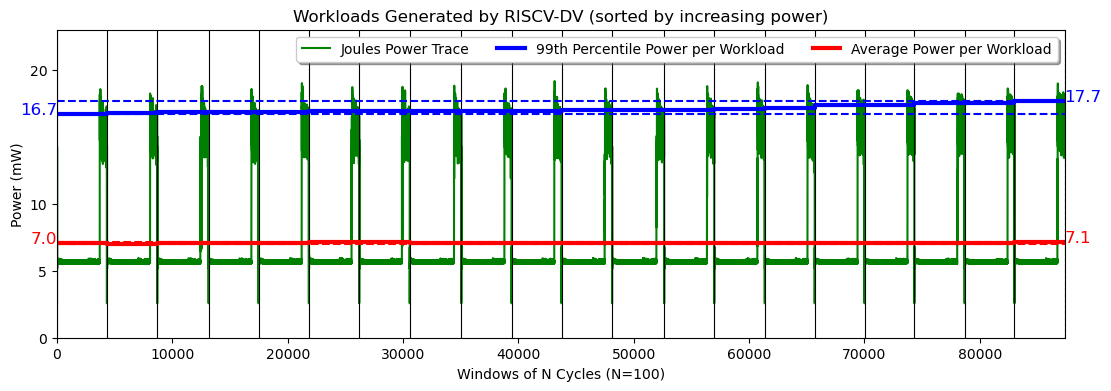

In [9]:
exec(open(f"{power_analysis_dir}/util.py").read())

percentile=99
workload_maxpow_dict = {w:np.percentile(jpower_riscvdv[b[0]:b[1]], percentile) for w,b in wb_riscvdv.items()}
jpower_sorted, workload_borders_sorted = reorder_jpower(jpower_riscvdv, wb_riscvdv, workload_vals=workload_maxpow_dict)

plot_power(jpower_sorted, workload_borders=workload_borders_sorted.values())
plot_power_vals(workload_borders_sorted, workload_maxpow_dict, c='b', label=f'{percentile}th Percentile Power per Workload')
plot_power_vals(workload_borders_sorted, c='r')

plt.title('Workloads Generated by RISCV-DV (sorted by increasing power)')
plt.ylim(top=max(jpower_riscvdv)*1.2)
plt.yticks([0,5,10,20])
plt.legend(ncol=3, framealpha=1, shadow=True);

''

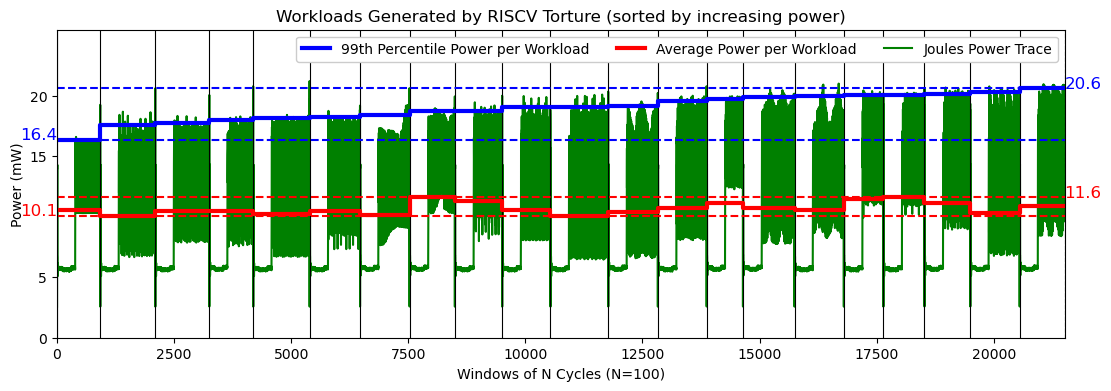

In [38]:
exec(open(f"{power_analysis_dir}/util.py").read())

percentile=99
workload_maxpow_dict = {w:np.percentile(jpower_torture[b[0]:b[1]], percentile) for w,b in wb_torture.items()}
jpower_sorted, workload_borders_sorted = reorder_jpower(jpower_torture, wb_torture, workload_vals=workload_maxpow_dict)

plot_power(jpower_sorted, workload_borders=workload_borders_sorted.values())
plot_power_vals(workload_borders_sorted, workload_maxpow_dict, c='b', label=f'{percentile}th Percentile Power per Workload')
plot_power_vals(workload_borders_sorted, get_workload_avgpow(riscv_torture), c='r')

ax = plt.subplot()
handles, labels = ax.get_legend_handles_labels()
idxs = [1,2,0]
ax.legend([handles[i] for i in idxs], [labels[i] for i in idxs], 
          loc='upper right', bbox_to_anchor=(1,1), ncol=3, 
            frameon=True, framealpha=1)
plt.yticks([0,5,15,20])
plt.ylim(top=max(jpower_torture)*1.2)
plt.title('Workloads Generated by RISCV Torture (sorted by increasing power)')

;

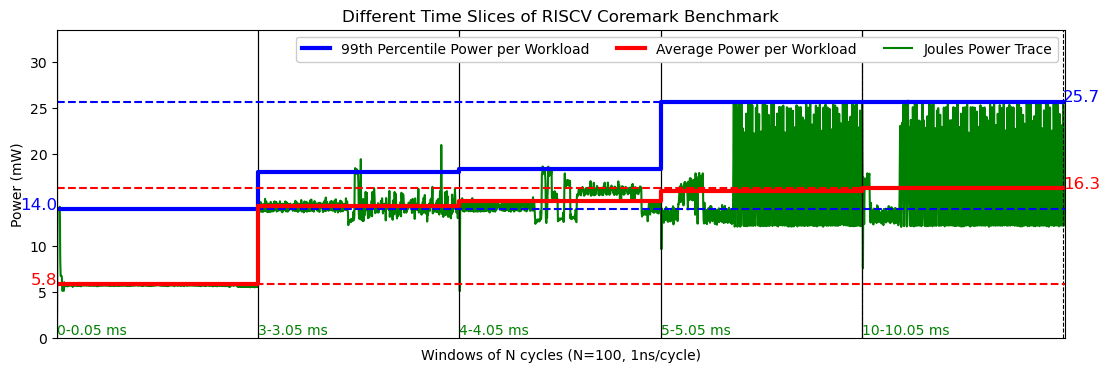

In [26]:
exec(open(f"{power_analysis_dir}/util.py").read())

base_dir = f"{build_dir}/chipyard.TestHarness.RocketConfig-ChipTop/power-rtl-rundir/plot_profile"
jpower_coremark = []
xs = []
times = [0,3,4,5,10]
for ms in times:
    fpath = f"{base_dir}/coremark.bare-{ms}ms-500w.png.data"
    _, jpower_cmark_temp = read_profile_file(profile_file=fpath)
    jpower_coremark += jpower_cmark_temp
    xs += [i+ms for i in range(len(jpower_cmark_temp))]
plot_power(jpower_coremark, workload_borders=[(i*500,i*500) for i in range(len(times))])

wb_coremark = {f"{t}-{t}.05 ms": (i*500,i*500+500) for i,t in enumerate(times)}
workload_avg_dict = {w:np.sum(jpower_coremark[b[0]:b[1]])/(b[1]-b[0]) for w,b in wb_coremark.items()}

plot_borders(wb_coremark,
             rotation=0)

workload_maxpow_dict = {w:np.percentile(jpower_coremark[b[0]:b[1]], percentile) for w,b in wb_coremark.items()}

plt.title('Different Time Slices of RISCV Coremark Benchmark')
# plot_power(jpower_sorted, workload_borders=workload_borders_sorted.values())
plot_power_vals(wb_coremark, workload_maxpow_dict, c='b', label=f'{percentile}th Percentile Power per Workload')
plot_power_vals(wb_coremark, workload_avg_dict, c='r')
plt.ylim(top=1.3*max(jpower_coremark))
plt.yticks([0,5,10,20,25,30])
ax = plt.subplot()
handles, labels = ax.get_legend_handles_labels()
idxs = [1,2,0]
ax.legend([handles[i] for i in idxs], [labels[i] for i in idxs], 
          loc='upper right', bbox_to_anchor=(1,1), ncol=3, 
            frameon=True, framealpha=1)
plt.xticks([]); plt.xlabel("Windows of N cycles (N=100, 1ns/cycle)");